# Agrupamento de Imagens

A técnica de agrupamento consiste em *rotular* elementos de um conjunto de dados inicialmente não-rotulados com base na semelhança existente entre esses elementos. A ideia é que elementos que possuem características semelhantes devem pertencer a um mesmo tipo.

No mundo real, a maior quantidade de dados existentes não possuem rótulos prévios. Dessa maneira, aprender como funcionam os algoritmos de agrupamento é vital para conseguir tratar problemas complexos.

Neste notebook, vamos somente demonstrar o que seria o agrupamento com base nas características intrínsecas de imagens: suas cores. O objetivo é separar em grupos os objetos (simples círculos de cores diferentes) que estão dentro de uma mesma imagem.

Vamos utilizar o algoritmo mais conhecido e, ao mesmo tempo, mais simples para fazer o agrupamento: o *k*-means. Esse algoritmo é particional, baseado em distância e iterativo. Ele agrupa os dados em torno de pontos concentradores de dados (os centróides). Mais informações sobre o algoritmo podem ser encontradas [aqui](https://en.wikipedia.org/wiki/K-means_clustering).

Para realizar o agrupamento, vamos fazer uso do pacote `KMeans` do `sklearn.cluster`.

## Criando um cenário

Vamos construir uma imagem composta de diversos círculos com cores diferentes. Essa imagem pode representar, por exemplo, uma placa com reagentes e o objetivo é filtrar os tipos de reação com base na cor desses reagentes. Nesse caso, os reagentes são representados (coincidentemente) pelas cores vermelho, verde e azul.

In [4]:
# importando pacotes
from sklearn.cluster import KMeans
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow

import imutils

# lista de cores
colors = [
	# shades of red, green, and blue
	(138, 8, 8), (180, 4, 4), (223, 1, 1), (255, 0, 0), (250, 88, 88),
	(8, 138, 8), (4, 180, 4), (1, 223, 1), (0, 255, 0), (46, 254, 46),
	(11, 11, 97), (8, 8, 138), (4, 4, 180), (0, 0, 255), (46, 46, 254)]
#  canvas
canvas = np.ones((400, 600, 3), dtype="uint8") * 255
# loop no canvas
for y in range(0, 400, 20):
	for x in range(0, 600, 20):
		# gera coordenada aleatoria (x, y), raio, e cor para o circulo
		(dX, dY) = np.random.randint(5, 10, size=(2,))
		r = np.random.randint(5, 8)
		color = random.choice(colors)[::-1]
		# desenha o circulo
		cv2.circle(canvas, (x + dX, y + dY), r, color, -1)
# cria uma borda no canvas
canvas = cv2.copyMakeBorder(canvas, 5, 5, 5, 5, cv2.BORDER_CONSTANT,
	value=(255, 255, 255))

Ao final desse processo, temos a seguinte imagem para tratar.

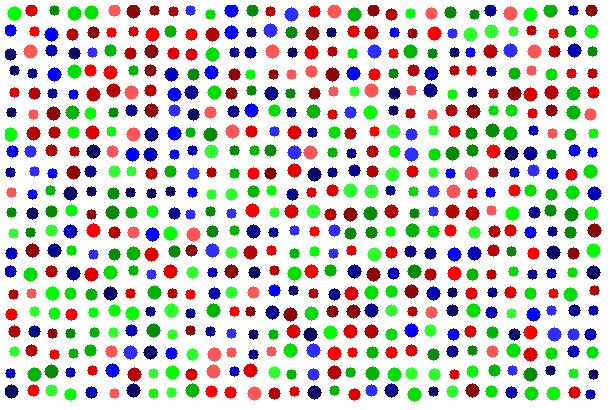

In [ ]:
cv2_imshow(canvas)

## Destacando os objetos

Uma vez de posse da imagem contendo os objetos coloridos, devemos conseguir capturar individualmente cada um deles. Para isso, vamos utilizar dois procedimentos básicos:

- *thresholding*: binarizar a imagem e separar o fundo do objeto de interesse.
- extrair contornos: devemos detectar os contornos para poder extrair cada um dos objetos.

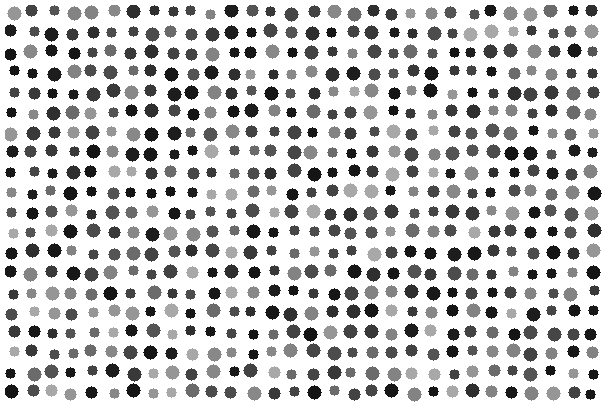

In [ ]:
# converte a imagem para escala de cinza para facilitar a binarização
gray = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

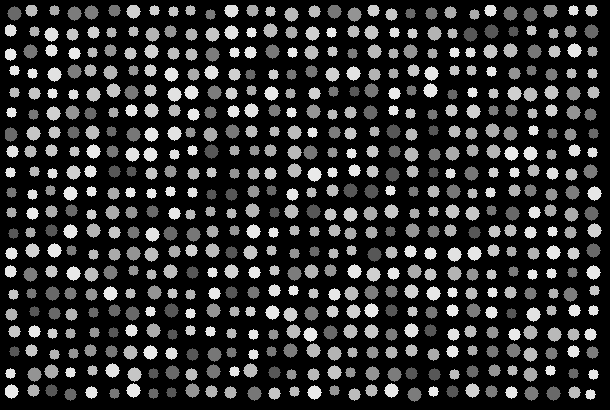

In [ ]:
# inverte os bits da imagem para destacar os objetos de frente e deixar o fundo preto.
gray = cv2.bitwise_not(gray)
cv2_imshow(gray)

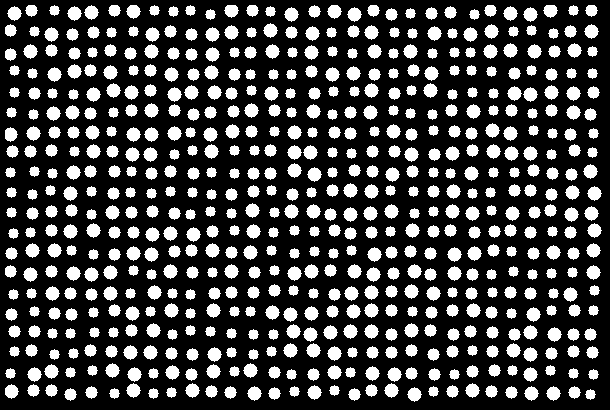

In [ ]:
# aplica a binarização para deixar
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
cv2_imshow(thresh)

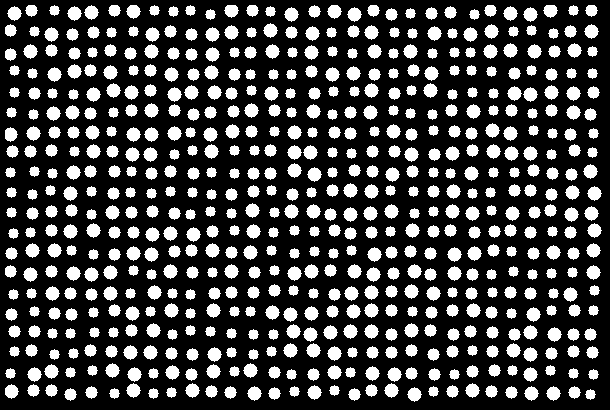

In [ ]:
# extrai os contornos dos objetos da imagem.
cnts = cv2.findContours(gray.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# novo canvas só para exibir contornos
canvas_tmp = np.ones((400, 600), dtype="uint8") * 0
canvas_tmp = cv2.copyMakeBorder(canvas_tmp, 5, 5, 5, 5, cv2.BORDER_CONSTANT,
	value=(0,0,0))

# loop por todos os contornos.
for c in cnts:
  # cria mascara a partir dos contornos
  mask = np.zeros(canvas_tmp.shape[:2], dtype="uint8")
  # desenha contornos
  cv2.drawContours(mask, [c], -1, 255, -1)
  # adiciona contorno no canvas
  canvas_tmp = cv2.bitwise_or(canvas_tmp, mask)

# mostra os contornos extraídos da imagem
cv2_imshow(canvas_tmp)

In [ ]:
# cria a base de dados a partir do valor médio de RGB dos pixels da imagem original
# que estão destacados por cada contorno extraído.

# array para armazenar dados
data = []

# loop por todos os contornos
for c in cnts:
  # cria canva a ser utilizado como máscara 
  mask = np.zeros(canvas.shape[:2], dtype="uint8")
  # desenha contornos na máscara
  cv2.drawContours(mask, [c], -1, 255, -1)
  # extrai as features do objeto (valor médio de RGB)
  features = cv2.mean(canvas, mask=mask)[:3]
  # adiciona as features ao array de dados
  data.append(features)

In [ ]:
# exemplo de uma entrada da base de dados
print(data[0])

# número de entradas na base de dados
print(len(data))

(180.0, 4.0, 4.0)
600


## Agrupando

Com a base de dados formada, temos que realizar o agrupamento das instâncias (entradas) presentes nela. Cada uma dessas entradas corresponde ao um círculo detectado na imagem.

Vamos utilizar o algoritmo *k-means* para isso. A função já foi importada no início do notebook e ela é a `KMeans()`.

Vale salientar que o algoritmo *k-means* tem como parâmetro obrigatório, o número de grupos desejado. A quantidade de grupos depende muito da necessidade do problema. Nesse caso, como sabemos os tipos de reagentes (problema hipotético) que temos e o que queremos é, na verdade, filtrar os pontos da imagem que são dessas cores. Assim, o número de grupos definido vai ser igual a três.

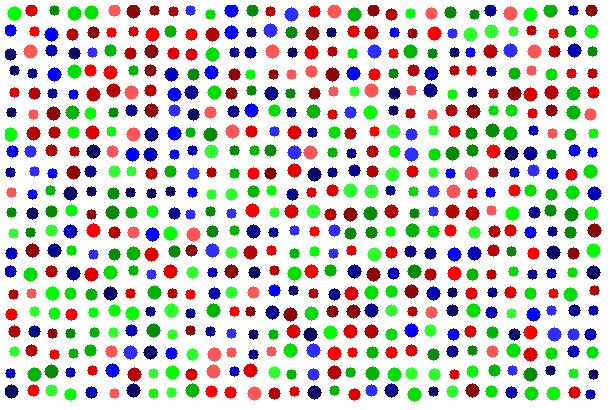

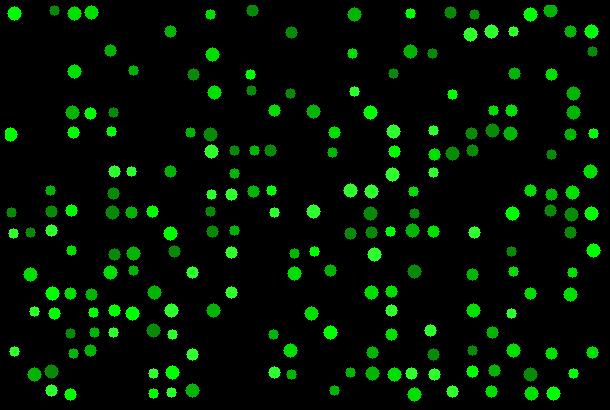

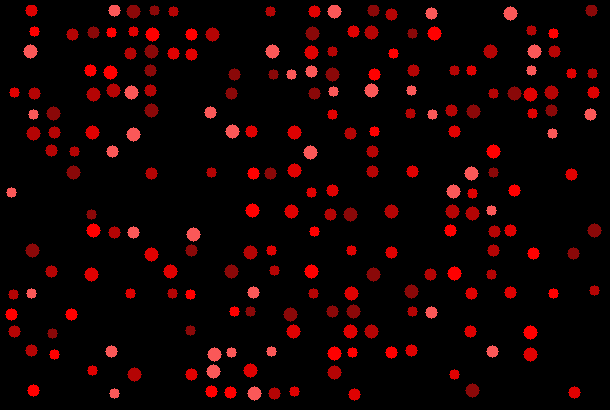

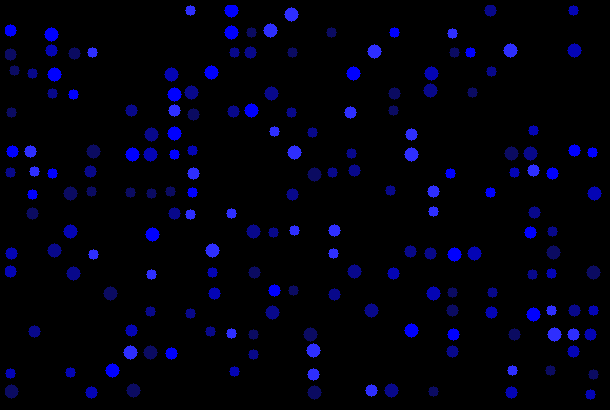

In [ ]:
# inicializa o k-means com três grupos
clt = KMeans(n_clusters=3)
# agrupa a partir das caracteristicas extraídas (cores)
clt.fit(data)
# mostra a imagem inicial para comparação
cv2_imshow(canvas)
# loop pelos grupos encontrados pelo k-means
for i in np.unique(clt.labels_):
	# cria a mascara do grupo atual
	mask = np.zeros(canvas.shape[:2], dtype="uint8")
	# loop nos objetos do cluster para desenhar cada um deles
	for j in np.where(clt.labels_ == i)[0]:
		cv2.drawContours(mask, [cnts[j]], -1, 255, -1)
	# mostra a imagem final
	cv2_imshow(cv2.bitwise_and(canvas, canvas, mask=mask))

Imagine que somente os valores que possuem uma determinada saturação são considerados válidos para um determinado reagente. Nesse caso, podemos filtrar os elementos que ultrapassam esse limiar. 

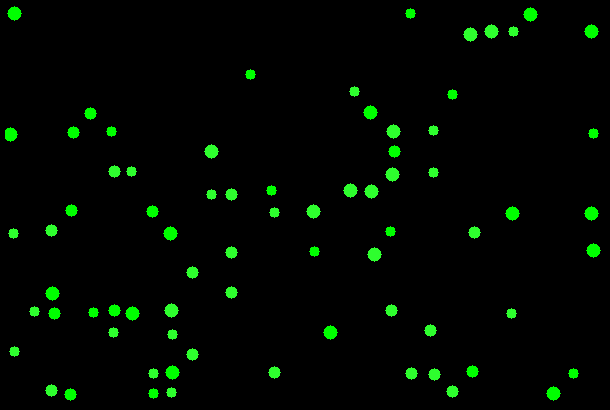

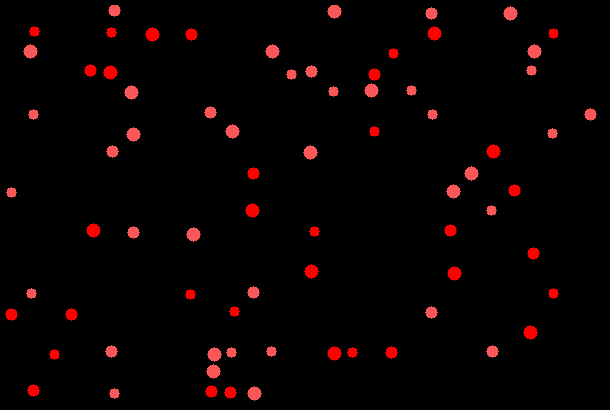

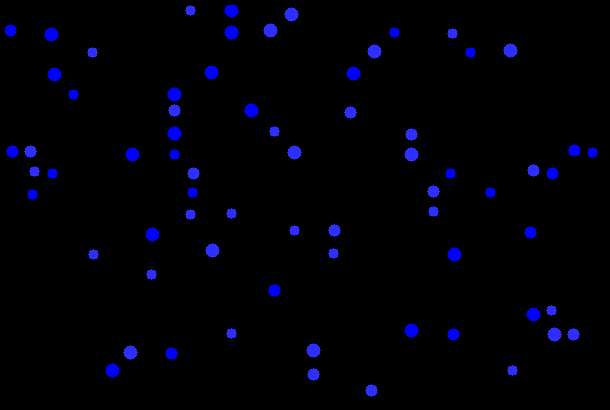

In [ ]:
for i in np.unique(clt.labels_):
  # cria a mascara do grupo atual
  mask = np.zeros(canvas.shape[:2], dtype="uint8")
  # loop nos objetos do cluster para desenhar cada um deles
  for j in np.where(clt.labels_ == i)[0]:
    # filtra elementos que não possuem cor principal maior que 240
    if max(data[j]) > 240:
      cv2.drawContours(mask, [cnts[j]], -1, 255, -1)
  # mostra a imagem final
  cv2_imshow(cv2.bitwise_and(canvas, canvas, mask=mask))

# Agrupamento de cenários

Um outro exemplo que podemos mostrar sobre o agrupamento de imagens consiste na divisão de fotos em grupos para fins de organização, por exemplo. Esse tipo de problema é bastante comum em vários aplicativos atuais, que buscam ajudar o usuário a organizar melhor suas fotos, dividindo-as em grupos cuja categoria fica evidenciada a um simples olhar de um exemplar do grupo.

Aqui, vamos agrupar fotos de cenários abertos, mas em condições diferentes. Esse é o mesmo conjunto de dados que vimos antes quando exploramos a classificação de imagens. No entanto, não vamos utilizar os rótulos existentes durante o processo de agrupamento. Os únicos dados que serão utilizados são aqueles que podem ser extraídos a partir da própria imagem.

Os passos para isso são mostrados a seguir.


In [ ]:
# importando os pacotes necessários
import cv2
import os
from sklearn.cluster import KMeans
import numpy as np
import random
from google.colab.patches import cv2_imshow

## Baixando a base de dados

In [ ]:
# baixando o conjunto de dados
# se os dados já foram baixados, pule esta etapa ou apague os arquivos do drive.
!wget 'https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana02/03/codigo/4scenes.zip'
!ls -l

--2022-02-02 23:09:17--  https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana02/03/codigo/4scenes.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana02/03/codigo/4scenes.zip [following]
--2022-02-02 23:09:18--  https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana02/03/codigo/4scenes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54187202 (52M) [application/zip]
Saving to: ‘4scenes.zip’

4scenes.zip         100%[===================>]  51.68M   237MB/s    in 0.2s    

2022-02-02 23:09:19 (237 MB/s) - ‘4s

Como pode ser visto, o nosso conjunto de imagens possui em torno de 50MB. Precisamos descompactar o arquivo para ter acesso aos dados de interesse.

In [ ]:
# descompactando o conjunto de dados
# se a pasta já foi descompactada, pule esta etapa ou apague as pastas
!unzip '/content/4scenes.zip'

Archive:  /content/4scenes.zip
   creating: 4scenes/
  inflating: 4scenes/highway_gre141.jpg  
  inflating: 4scenes/highway_bost389.jpg  
  inflating: 4scenes/highway_gre155.jpg  
  inflating: 4scenes/coast_natu641.jpg  
  inflating: 4scenes/forest_land314.jpg  
  inflating: 4scenes/street_street61.jpg  
  inflating: 4scenes/forest_nat449.jpg  
  inflating: 4scenes/forest_cdmc451.jpg  
  inflating: 4scenes/street_hexp29.jpg  
  inflating: 4scenes/highway_bost148.jpg  
  inflating: 4scenes/forest_land102.jpg  
  inflating: 4scenes/highway_bost160.jpg  
  inflating: 4scenes/highway_bost174.jpg  
  inflating: 4scenes/coast_n203030.jpg  
  inflating: 4scenes/street_bost50.jpg  
  inflating: 4scenes/forest_nat717.jpg  
  inflating: 4scenes/forest_cdmc280.jpg  
  inflating: 4scenes/street_bost137.jpg  
  inflating: 4scenes/highway_urb710.jpg  
  inflating: 4scenes/forest_natu308.jpg  
  inflating: 4scenes/coast_land113.jpg  
  inflating: 4scenes/coast_natu912.jpg  
  inflating: 4scenes/stree

Depois de descompactar o conjunto de dados, vamos dar uma olhada em uma amostra, juntamente com algumas outras informações.

Amostra de imagem da base:


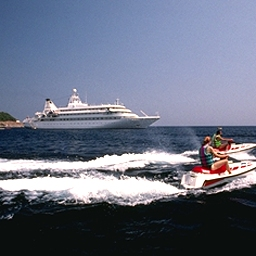

Tamanho de cada imagem: (256, 256, 3)
Quantidade de imagens: 1240


In [ ]:
print('Amostra de imagem da base:')
cv2_imshow(sample_image)

sample_image = cv2.imread('4scenes/coast_arnat59.jpg')
print(f'Tamanho de cada imagem: {sample_image.shape}')
num_files = len([name for name in os.listdir('/content/4scenes/') if os.path.isfile('/content/4scenes/' + name)])
print(f'Quantidade de imagens: {num_files}')

## Extraindo características

Para agrupar as imagens, não vamos utilizar diretamente os valores de intensidade de cores. Para esse tipo de tarefa, é mais indicado que façamos a extração de características da imagem para utilizar como entrada do algoritmo.

Existem muitas possibilidades de extratores, mas vamos recorrer a um bem simples, o [histograma de cores](https://en.wikipedia.org/wiki/Color_histogram). O histograma consiste em dividir o espaço de cores em larguras fixas (*bins*) e literalmente contar quantas vezes os pixels com intensidades de cores dentro daquele intervalo existem na imagem. Se pensarmos nos três canais de cores, teremos três divisões distintas (que podem ter tamanhos iguais) e a contabilização em cada uma delas vai ser uma característica da nossa base de dados.

Mas, antes... como vamos extrair os histogramas das imagens para utilizaer como características, uma passo importante antes de realizer a contagem é a conversão do espaço de cores.

No espaço L\*a\*b, a distância euclidiana entre duas cores possui significado. Dessa maneira, como vamos utilizar o *k-means* como algoritmo de agrupamento e ele também vai utilizar a distância euclidiana, faz bastante sentido realizar essa conversão.

Na célula seguinte vamos criar uma função que extrai as características de uma imagem usando os conceitos e procedimentos que vimos agora.

In [ ]:
def describe(image, mask=None):
  # define o tamanho dos bins para o histograma
  bins = [8, 8, 8]
  # converte a imagem para o espaço L*a*b
  lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  # computa o histograma
  hist = cv2.calcHist([lab], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
  # normaliza o histograma
  hist = cv2.normalize(hist,hist).flatten()
  # retorna o histograma
  return hist

É muito importante realizar esse último passo de normalização do histograma. Caso contrário, imagens com o mesmo conteúdo, mas de tamanhos diferentes vão ter histogramas completamente diferentes. Com isso, a largura e altura da imagem não exerce influência na extração dos histogramas.

Vamos agora extrair, de fato, as features de cada uma das imagens do conjunto de dados e organizar tudo em listas para uso posterior.

In [ ]:
imagesPath = './4scenes'
labels = []
data = []
images = []

files = os.listdir(imagesPath)

print("[INFO] extraindo features...")

# loop em todas as imagens do diretório
for image_name in files:
  # extraindo o rótulo das imagens (primeira parte do nome do arquivo)
  label = image_name[image_name.rfind("/") + 1:].split("_")[0]
  # carregando a imagem
  image = cv2.imread(imagesPath+'/'+image_name)  
  # extraindo as features da imagem
  features = describe(image)
  # adicionando o rótulo da imagem (classe) em uma lista de rótulos
  labels.append(label)
  # adicionando a imagem (features) ao conjunto de dados
  data.append(features)
  # armazenando as imagens
  images.append(image)

[INFO] extraindo features...


## Agrupando

No passo anterior, os rótulos das imagens foram extraídos a partir dos nomes dos arquivos, mas não vamos utilizar em qualquer momento durante o processo de agrupamento.

Vamos utilizar o algoritmo *k-means* para realizar o agrupamento. Nesse caso, assumindo que não sabemos como a base de dados está distribuída, iniciamos agrupando com um número de grupos pequeno e podemos ir aumentando esse valor, sempre observando o resultado que obtemos.

Vamos fazer um teste e agrupar os dados em dois grupos.

In [ ]:
# agrupa os dados de histograma de cores
clt = KMeans(n_clusters=2)
output = clt.fit_predict(data)

O resultado do agrupamento vai ser somente um conjunto de rótulos que indicam para qual grupo os objetos foram atribuídos (nesse caso, 0 ou 1 para os dois grupos que solicitamos o agrupamento).

In [ ]:
print(output)

[0 1 0 ... 1 1 1]


É interessante alguma forma de visualização do agrupamento gerado. Vamos então, definir uma função que sorteia algumas imagens de cada grupo e as exibe.

In [ ]:
# função para mostrar as exemplos de imagens de cada grupo
def print_labeled_images(labels, images):
  num_samples = 10
  # tamanho para redimensionar a imagem e facilitar a visualização
  size = 70
  # loop por cada grupo para exibir imagens deles
  for i in np.unique(labels):
    # extrai os indices dos objetos com o label atual
    labels_ = np.where(labels == i)[0]
    # sorteia 3 índices aleatórios do conjunto de rótulos atual
    rand_samples = np.random.randint(0,len(labels_),size=(num_samples,1))
    # cria canvas vazio para incluir as imagens
    img_total = np.zeros((size,size*num_samples,3), dtype="uint8")
    k = 0
    images_ = images[labels_]
    for j in rand_samples:
      image = images_[j[0]]
      resized = cv2.resize(image, (size,size), interpolation = cv2.INTER_AREA)
      img_total[:,size*k:size*k+size,:] = resized
      k += 1
    print(f'imagens do grupo {i}')
    cv2_imshow(img_total)


imagens do grupo 0


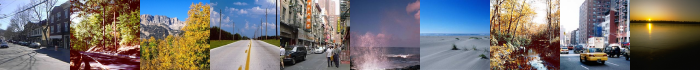

imagens do grupo 1


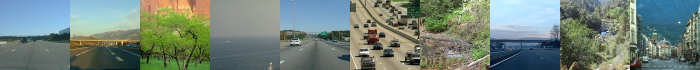

In [ ]:
# para facilitar o acesso das imagens, vamos transformar a lista de imagens
# em um array numpy.
images_array = np.array(images)
# iprimindo o resultdo para o agrupamento anterior.
print_labeled_images(output, images_array)

Com esse agrupamento, não deu para notar qualquer padrão visível na divisão. Vamos aumentar o número de grupos.

imagens do grupo 0


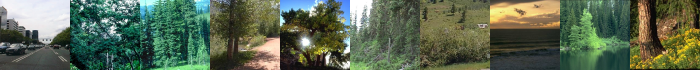

imagens do grupo 1


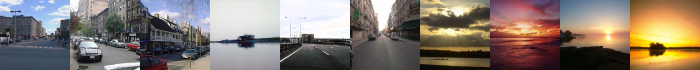

imagens do grupo 2


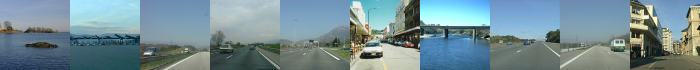

In [ ]:
clt = KMeans(n_clusters=3, random_state=42)
output = clt.fit_predict(data)
print_labeled_images(output, images_array)

Com esse resultado, é possível perceber que um dos grupos tende a ir colocar as imagens de árvores e outro, de estradas. Mas, nada muito claro ainda.

Nós podemos continuar subindo a quantidade de grupos até achar algo satisfatório. Mas, existe uma forma mais organizada de fazer isso.

*Disclaimer: como o k-means é um algoritmo não-determinístico, foi inserido uma seed fixa para os resultados serem iguais a cada execução.*

## Elbow

Quando não conseguimos definir o número de grupos a partir de uma análise inicial, devemos recorrer a uma estratégia de avaliação do agrupamento. Para isso, costumeiramente, executamos o algoritmo com variados números de grupos e calculamos a qualidade da partição gerada a partir de um índice.

A ideia é verificar o comportamento das partições a medida que o número de grupos cresce. Para isso, o que fazemos é plotar os valores dos índices relacionados ao número de grupos.

O índice mais básico que podemos usar é a própria variação intra-cluster dos grupos gerados pelo *k-means*. Esse valor é conhecido como *inertia* ou erro quadrático médio.

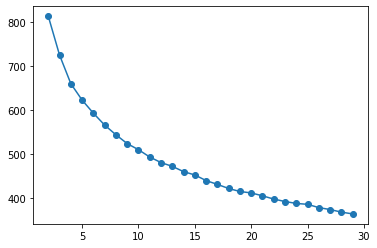

In [ ]:
import matplotlib.pyplot as plt

# intervalo de valores para o número de grupos: de 2 a 30
ks = range(2, 30)
# lista para armazenar todos os valores de índice de cada agrupamento
inertias = []
for k in ks:    
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data)
    # calcula a inertia, ou a variação intra-cluster do agrupamento
    inertias.append(km.inertia_)

# plota o valor dos índices com relação ao número de grupos.    
plt.plot(ks, inertias, marker='o')

Por ser uma medida de variância intra-cluster, é normal que os valores sejam descrescentes. No entanto, é esperado alguma mudança brusca de valores, o que indicaria uma disposição de grupos mais adequada. Essa mudança é comumente chamada de *elbow*.

Quando isso não acontece, recorremos a outras medidas. Uma delas é a [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)), que verifica a semelhança dos objetos dentro de um grupo comparada com a semalhança dos objetos com outros grupos.

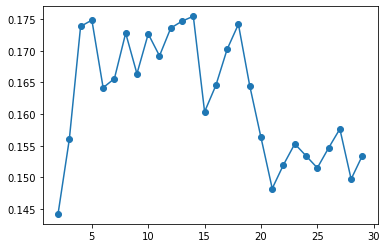

In [ ]:
from sklearn.metrics import silhouette_score

ks = range(2, 30)
silhouettes = []
for k in ks:    
    clt = KMeans(n_clusters=k, random_state=42)
    output = clt.fit_predict(data)
    s = silhouette_score(data,output)
    silhouettes.append(s)
    
plt.plot(ks, silhouettes, marker='o')

O valor da sihouette varia entre -1 e 1 e valores próximos a 1 são melhores enquanto que valores negativos indicam a colocação de elementos em grupos errados. Valores próximos a zero indicam sobreposição de grupos.

Nesse caso, os agrupamentos com 4, 5 e 14 grupos obtiveram os melhores valores. Vamos plotar abaixo essas configurações.

imagens do grupo 0


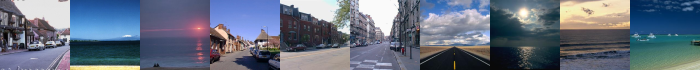

imagens do grupo 1


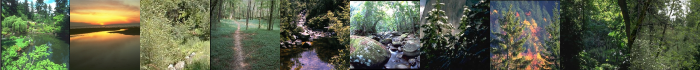

imagens do grupo 2


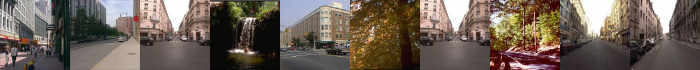

imagens do grupo 3


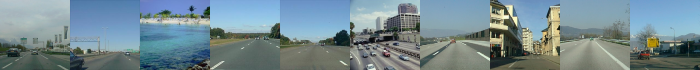

In [ ]:
clt = KMeans(n_clusters=4, random_state=42)
output = clt.fit_predict(data)
print_labeled_images(output, images_array)

imagens do grupo 0


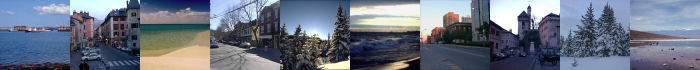

imagens do grupo 1


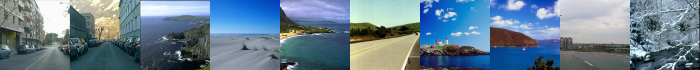

imagens do grupo 2


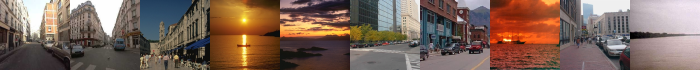

imagens do grupo 3


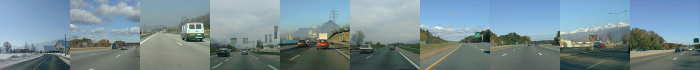

imagens do grupo 4


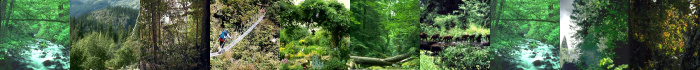

In [ ]:
clt = KMeans(n_clusters=5, random_state=42)
output = clt.fit_predict(data)
print_labeled_images(output, images_array)

In [ ]:
clt = KMeans(n_clusters=20, random_state=42)
output = clt.fit_predict(data)
print_labeled_images(output, images_array)

Output hidden; open in https://colab.research.google.com to view.

A partir da visualização das partições, é possível perceber que existe dois grupos bem definidos: imagens de natureza com floresta verde e imagens de estradas. Esses dois grupos apareceram quando agrupamos as imagens já com cinco grupos. O agrupamento com mais grupos trouxe um novo insight, existe um grupo somente com imagens de praias (grupo 17).

Note que essa divisão pode ou não fazer sentido de acordo com o problema. No nosso caso, o interessante é ir fazendo uma divisão automática de alguns cenários (aqueles que estão plenamente caracterizados) e os demais seriam redirecionados em momento posterior quando existirem mais imagens que possam 1) deixar as imagens mais próximas de um grupo existente ou 2) criar um grupo próprio.

Um outro ponto a ser notado é que o resultado dever ser diferente se usarmos um outro extrator de características mais robusto que possa, de fato, obter elementos das imagens que ajude na separação.

# Agrupando objetos

Um último exemplo sobre agrupamento de imagens é semalhante ao anterior, mas busca separar objetos e não cenários. A ideia é mostrar que, no momento que o problema se torna um pouco mais complexo, metodologias que funcionam muito bem, podem passar a não ser tão eficientes.

A base de dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consiste em uma grande coleção de imagens minúsculasd e 10 tipos de objetos diferentes. Ela é utilizada como benchmark em muitos cenários de testes de algoritmos de Visão Computacional.

A base original possui seis batches de 10.000 imagens, sendo 1.000 imagens de cada objeto. Ao todo, portanto, a base possui 60.000 imagens.

Para esse exemplo, vamos utilizar somente um dos batches.


## Obtendo e organizando os dados

Ao invés de baixar os dados da fonte oficial ( https://www.cs.toronto.edu/~kriz/cifar.html), vamos baixar uma versão que possui somente um dos batches da base.

In [8]:
# antes, vamos baixar novamente os pacotes
from sklearn.cluster import KMeans
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path

In [12]:
# se os dados já foram baixados, pule esta etapa ou apague os arquivos do drive.
my_file = Path("/content/cifar10.zip")
if my_file.is_file():
    !rm 'cifar10.zip'
!wget 'https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana02/03/codigo/cifar10.zip' -O 'cifar10.zip'

--2022-02-03 23:11:14--  https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana02/03/codigo/cifar10.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana02/03/codigo/cifar10.zip [following]
--2022-02-03 23:11:14--  https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana02/03/codigo/cifar10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28310971 (27M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>]  27.00M   159MB/s    in 0.2s    

2022-02-03 23:11:14 (159 MB/s) - ‘ci

In [22]:
# descompactando a base de dados
# se os dados já foram descompactados, pule essa etapa ou apague os arquivos.
my_folder = Path("/content/cifar10")
if my_folder.is_dir():
  !rm -rf '/content/cifar10'
my_folder = Path('/content/__MACOSX')
if my_file.is_dir():
  !rm -rf '/content/__MACOSX'
!unzip '/content/cifar10.zip'

Archive:  /content/cifar10.zip
   creating: cifar10/
  inflating: __MACOSX/._cifar10      
  inflating: cifar10/data_batch_1    
  inflating: __MACOSX/cifar10/._data_batch_1  
  inflating: cifar10/.DS_Store       
  inflating: __MACOSX/cifar10/._.DS_Store  
  inflating: cifar10/readme.html     
  inflating: __MACOSX/cifar10/._readme.html  
  inflating: cifar10/batches.meta    
  inflating: __MACOSX/cifar10/._batches.meta  


A base de dados, mesmo após a descompactação, está armazenada no formato [*pickle*](https://docs.python.org/pt-br/3/library/pickle.html). Esse formato serializa uma estrutura de dados da linguagem python em um arquivo binário. 

Vamos, então, montar uma função que encapsula o procedimento de desserialização do arquivo binário para podermos utilizar propriamente.

In [23]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Dos arquivos extraídos, vamos utilizar somente aquele referente ao primeiro batch de imagens e converter para arrays compatíveis com o nosso propósito.

In [24]:
batch1 = unpickle('/content/cifar10/data_batch_1')
images_array = batch1[b'data']

In [25]:
images_array.shape

(10000, 3072)

Dada a natureza como a base de dado foi montada, precisamos antes de tudo colocá-la em um formato que faça mais sentido para nossa abordagem. No arquivo original, cada imagem possui 32x32 pixels e três canais de cores. No entanto, esses dados foram armazenados de forma que os valores de cada canal foram colocados em sequencia um dos outros na seguinte ordem: vermelho, verde e azul. Assim, cada entrada do array é um vetor com 3.072 valores, sendo que os primeiros 1.024 são referentes ao valores do canal vermelho, os próximos 1.024 ao valores do canal verde e os últimos 1.024 são os do canal azul.

In [26]:
# função que mapeia os valores da forma como estão dispostos na base para o padrão
# utilizado pelo OpenCV.
def reshape(images_array):
  reshaped = images_array.reshape(10000,3,32,32)
  reshaped = reshaped.transpose(0,2,3,1)
  R = reshaped[:,:,:,0]
  G = reshaped[:,:,:,1]
  B = reshaped[:,:,:,2]
  images = np.zeros((10000,32,32,3), dtype=np.uint8)
  images[:,:,:,0] = B
  images[:,:,:,1] = G
  images[:,:,:,2] = R
  return images

In [27]:
images = reshape(images_array)

## Extração de características

A função a seguir é examente igual aquela utilizada no exemplo anterior que descreve a imagem a partir dos histogramas de cores dela.

In [28]:
def describe(image, mask=None):
  # define o tamanho dos bins
  bins = [4, 4, 4]
  # converte a imagem para o espaço L*a*b* 
  lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  # computa o histograma
  hist = cv2.calcHist([lab], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
  # normaliza o histograma
  hist = cv2.normalize(hist,hist).flatten()
  # return the histogram
  return hist

Agora, podemos, de fato, extrair as características de cada imagem.

In [29]:
data_list = [describe(image) for image in images]

Convertendo os dados para um numpy array.

In [30]:
data = np.array(data_list)
data.shape

(10000, 64)

## Agrupamento

Vamos aplicar a mesma metodologia do exemplo anterior, utilizando o método do *elbow*.

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [32]:
ks = range(2, 30)
silhouettes = []
for k in ks:    
    clt = KMeans(n_clusters=k, random_state=42)
    output = clt.fit_predict(data)
    s = silhouette_score(data,output)
    silhouettes.append(s)

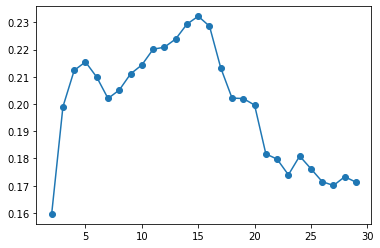

In [ ]:
plt.plot(ks, silhouettes, marker='o')

Os melhores resultados foram com cinco e dez grupos. Vamos agrupar com esses valores.

Mas, vamos novamente definir uma função para visualizar algumas imagens aleatórias atribuídas a cada grupo.


In [34]:
# função para mostrar as exemplos de imagens de cada grupo
def print_labeled_images(labels, images):
  num_samples = 15
  # tamanho para redimensionar a imagem e facilitar a visualização
  size = 50
  # loop por cada grupo para exibir imagens deles
  for c in np.unique(labels):
    # obtem os indices referentes ao cluster atual
    idx_c = labels == c
    # separa as imagens do cluster atual
    images_c = images[idx_c]
    # determina num_samples indices aleatórios para serem amostrados do cluster    
    idx_r = np.random.randint(0,len(images_c),size=num_samples)
    rand_samples = images_c[idx_r]    
    # cria canvas vazio para incluir as imagens
    img_total = np.zeros((size,size*num_samples,3), dtype="uint8")    
    
    k = 0    
    for s in rand_samples:
      resized = cv2.resize(s, (size,size), interpolation = cv2.INTER_AREA)
      img_total[:,size*k:size*k+size,:] = resized
      k += 1
    
    print(f'imagens do grupo {c}')
    cv2_imshow(img_total)    

imagens do grupo 0


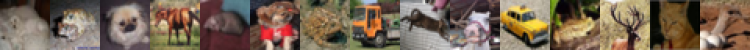

imagens do grupo 1


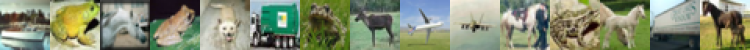

imagens do grupo 2


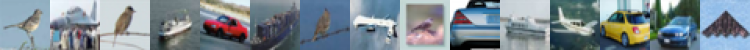

imagens do grupo 3


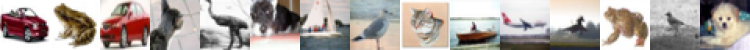

imagens do grupo 4


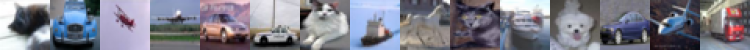

In [35]:
clt = KMeans(n_clusters=5, random_state=42)
output = clt.fit_predict(data)
print_labeled_images(output, images)

imagens do grupo 0


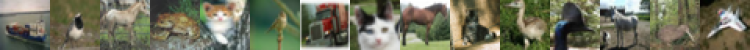

imagens do grupo 1


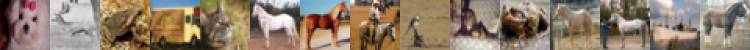

imagens do grupo 2


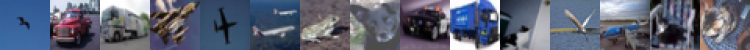

imagens do grupo 3


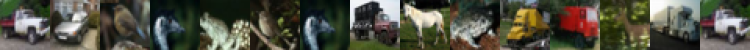

imagens do grupo 4


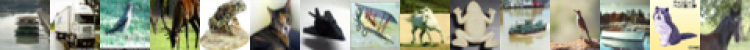

imagens do grupo 5


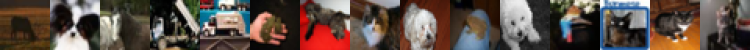

imagens do grupo 6


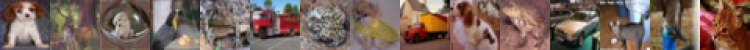

imagens do grupo 7


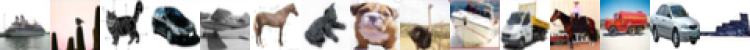

imagens do grupo 8


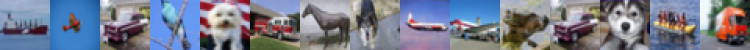

imagens do grupo 9


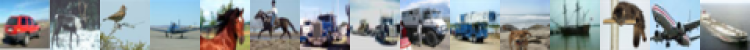

imagens do grupo 10


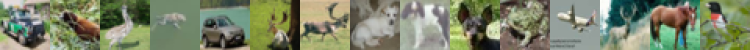

imagens do grupo 11


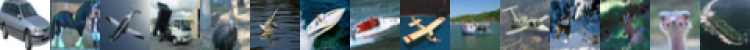

imagens do grupo 12


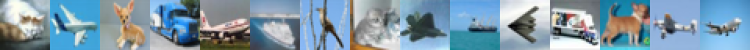

imagens do grupo 13


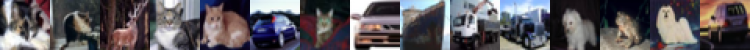

imagens do grupo 14


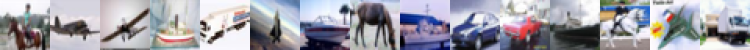

In [36]:
clt = KMeans(n_clusters=15, random_state=42)
output = clt.fit_predict(data)
print_labeled_images(output, images)

Como é possível perceber, com essa estratégia de extração de características e esse algoritmo de agrupamento, o resultado não foi satisfatório para um problema um pouco mais complexo.

Para obter melhores resultados, seria necessário uma forma de extrair características que melhor ajudassem a distinguir as imagens e/ou um algoritmo mais robusto para separação dos grupos.